In [38]:
# import the necessary packages
from imutils.perspective import four_point_transform
from skimage.segmentation import clear_border
from skimage import measure
import numpy as np
import imutils
import cv2
import matplotlib.pyplot as plt
from tensorflow import keras
import os

In [39]:
#with this first function, the sudoku is located - function is from https://pyimagesearch.com/2020/08/10/opencv-sudoku-solver-and-ocr/

def find_puzzle(image, debug=False):
    # Convert the image to greyscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # apply adaptive thresholding and then invert the threshold map
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 5, 1)
    thresh = cv2.bitwise_not(thresh)
    # check to see if we are visualizing each step of the image
    # processing pipeline (in this case, thresholding)
    if debug:
        plt.figure()
        plt.imshow(thresh)
    # find contours in the thresholded image and sort them by size in
    # descending order
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    # initialize a contour that corresponds to the puzzle outline
    puzzleCnt = None
    # loop over the contours
    for c in cnts:
        # approximate the contour
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        # if our approximated contour has four points, then we can
        # assume we have found the outline of the puzzle
        if len(approx) == 4:
            puzzleCnt = approx
            break
    # if the puzzle contour is empty then our script could not find
    # the outline of the Sudoku puzzle so raise an error
    if puzzleCnt is None:
        raise Exception(("Could not find Sudoku puzzle outline. "
            "Try debugging your thresholding and contour steps."))
    # check to see if we are visualizing the outline of the detected
    # Sudoku puzzle
    if debug:
        # draw the contour of the puzzle on the image and then display
        # it to our screen for visualization/debugging purposes
        output = image.copy()
        plt.figure()
        cv2.drawContours(output, [puzzleCnt], -1, (0, 255, 0), 2)
        plt.imshow(output)
    # apply a four point perspective transform to both the original
    # image and grayscale image to obtain a top-down bird's eye view
    # of the puzzle
    puzzle = four_point_transform(image, puzzleCnt.reshape(4, 2))
    warped = four_point_transform(gray, puzzleCnt.reshape(4, 2))
    # check to see if we are visualizing the perspective transform
    if debug:
        # show the output warped image (again, for debugging purposes)
        plt.figure()
        plt.imshow(puzzle)
    # return a 2-tuple of puzzle in both RGB and grayscale
    return (puzzle, warped)

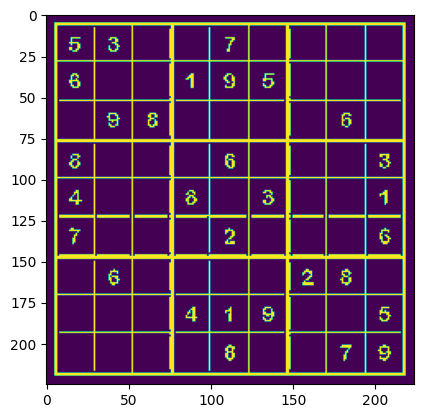

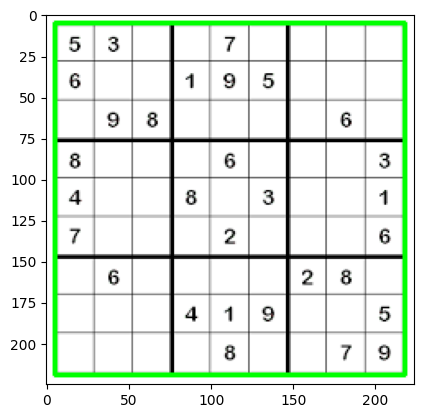

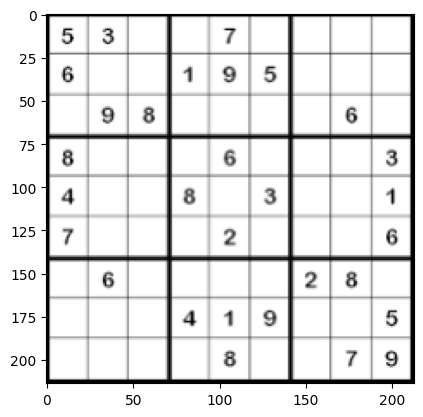

In [46]:
image_path = 'images/sudoku5.png'
image = cv2.imread(image_path)
(puzzle, warped) = find_puzzle(image, debug = True)

In [47]:
def keep_boundary_segments(image):
    # Label connected regions in the image
    labeled_image = measure.label(image)
    
    # Find the unique labels of the connected regions
    unique_labels = np.unique(labeled_image)
    
    # Get the image shape
    height, width = image.shape
    
    # Iterate over each label
    for label in unique_labels:
        # Extract the region corresponding to the label
        region = (labeled_image == label)
        
        # Check if the region touches the boundary
        touches_boundary = (
            np.any(region[0, :]) or  # Top boundary
            np.any(region[-1, :]) or  # Bottom boundary
            np.any(region[:, 0]) or  # Left boundary
            np.any(region[:, -1])  # Right boundary
        )
        
        # Check if the region also extends into the middle of the image
        extends_into_middle = (
            np.any(region[6:-6, 6:-6])  # Excluding the boundary pixels
        )
        
        # Remove the region if it only touches the boundary
        if not extends_into_middle:
            image[labeled_image == label] = 0
    
    return image

In [48]:
#might work, see https://pyimagesearch.com/2020/08/10/opencv-sudoku-solver-and-ocr/

def compute_digit(image, digit_model):
    # Resize the image to a fixed size (e.g., 28x28)
    image = cv2.resize(image, (28, 28))
    
    # Applying Gaussian Blur
    blurred_image = cv2.GaussianBlur(image, (3, 3), 0)
    
    # Apply adaptive thresholding
    thresh = cv2.adaptiveThreshold(blurred_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                    cv2.THRESH_BINARY_INV, 11, 2)
    
    # Check if the thresholding operation produced a valid thresholded image
    if thresh is None:
        return 0

    # Find contours in the thresholded cell
    cnts, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # If no contours were found, return None
    if len(cnts) == 0:
        return 0
    
    # Find the largest contour in the cell and create a mask for it
    c = max(cnts, key=cv2.contourArea)
    mask = np.zeros(thresh.shape, dtype="uint8")
    cv2.drawContours(mask, [c], -1, 255, -1)
    
    # Compute the percentage of masked pixels relative to the total area of the image
    (h, w) = thresh.shape
    percentFilled = cv2.countNonZero(mask) / float(w * h)

    # If less than 3% of the mask is filled then it's likely noise, so ignore it
    if percentFilled < 0.03:
        return 0

    # Apply the mask to the thresholded cell
    digit = cv2.bitwise_and(thresh, thresh, mask=mask)
    digit = keep_boundary_segments(digit)
    plt.figure()
    plt.imshow(digit)
    plt.show()
    
    digit = np.asarray(digit)
    digit = digit / 255.0
    digit = np.expand_dims(digit, axis=0)
    digit = np.expand_dims(digit, axis=-1)
    return np.argmax(digit_model.predict(digit, verbose=False))

In [49]:
def compile_model():
    # Define the model architecture
    model = keras.Sequential([
        keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(10, activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Set already trained weights
    model.load_weights('model_training/digit_recognizer_test.h5')
    
    # Return compiled model with trained weights
    return model

In [52]:
def recognize_sudoku(image):
    digit_model = compile_model()
    (puzzle, warped) = find_puzzle(image)
    l, h = warped.shape
    A = np.zeros((9,9))
    for i in range(9):
        for j in range(9):
            puzzle_ij = warped[int(l/9*i):int(l/9*(i+1)), int(h/9*j):int(h/9*(j+1))]
            A[i,j] = compute_digit(puzzle_ij, digit_model)
            plt.figure()
            plt.imshow(puzzle_ij)
            plt.show()
            if A[i,j] != 0:
                print(A[i,j])
    return A

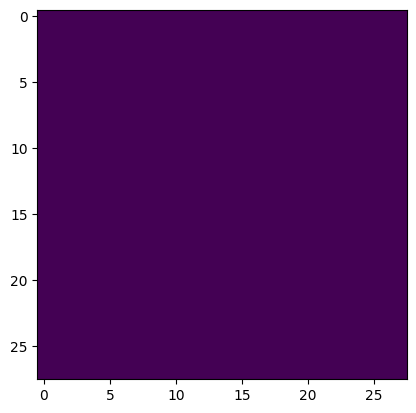

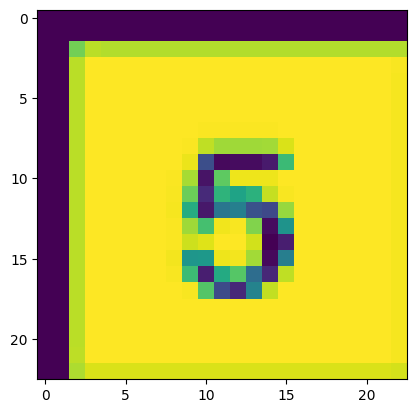

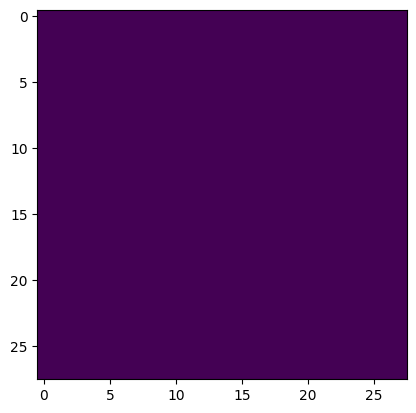

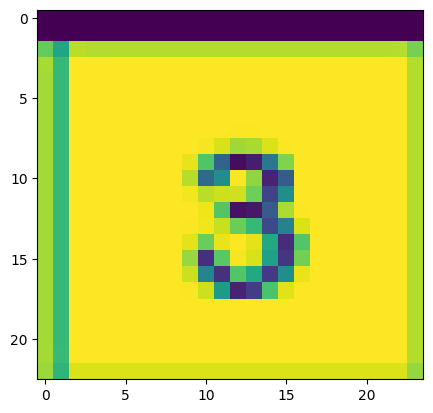

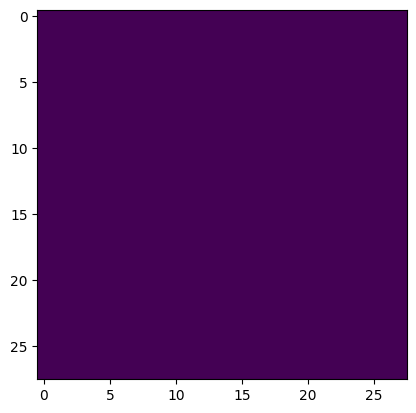

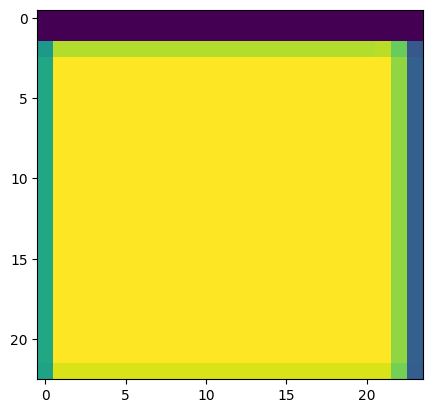

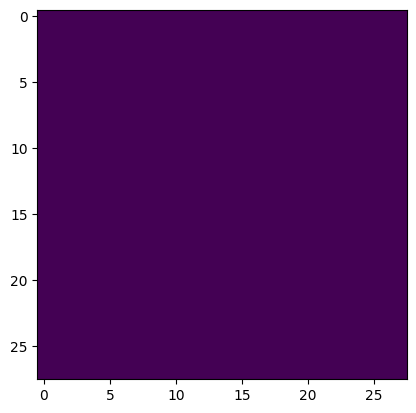

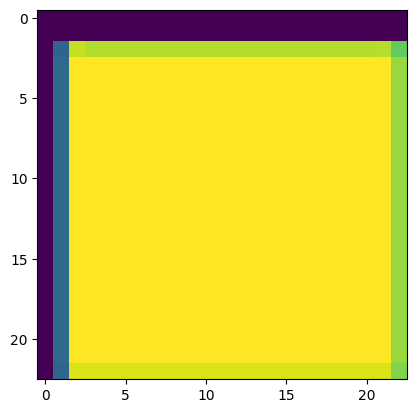

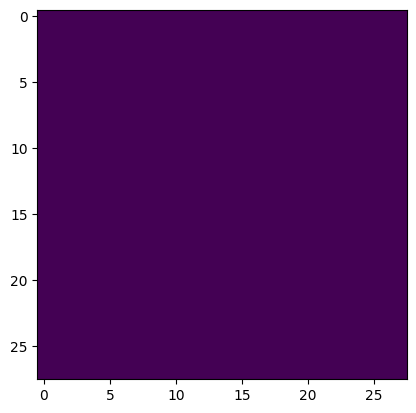

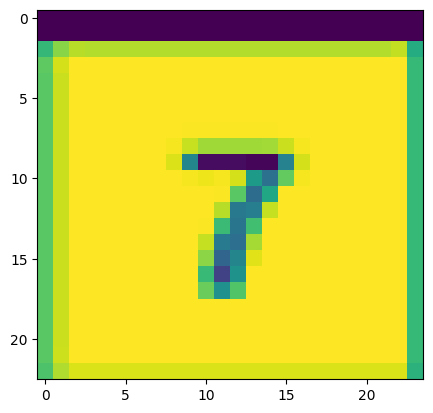

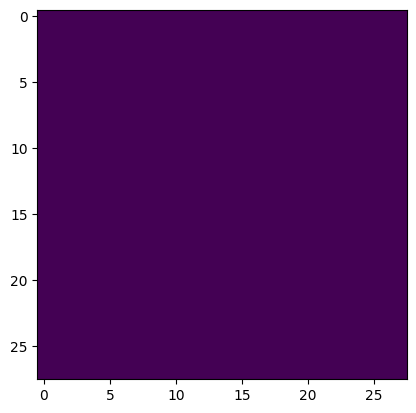

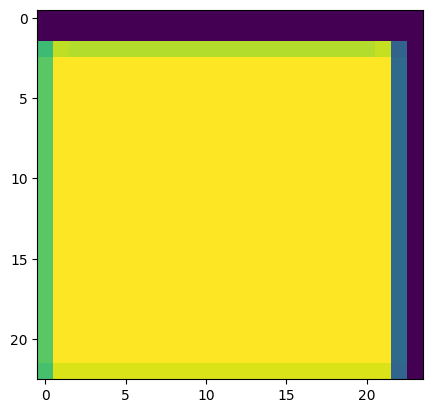

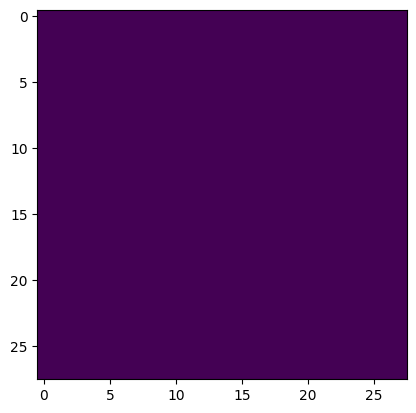

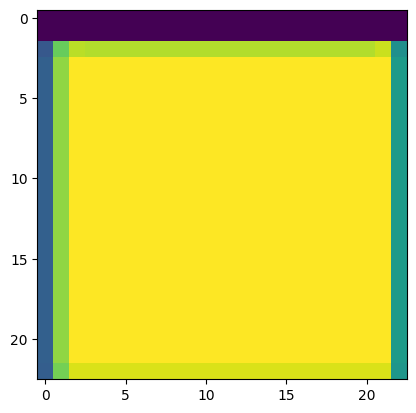

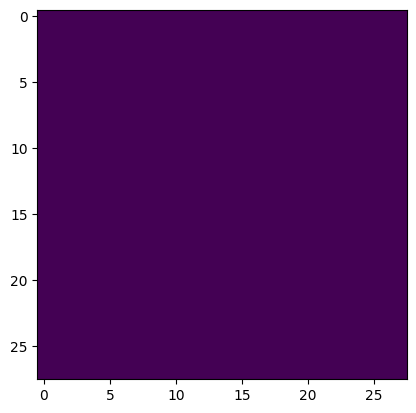

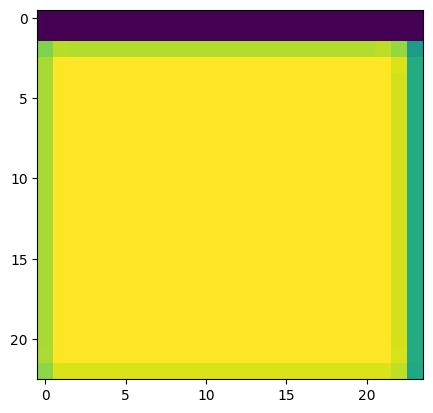

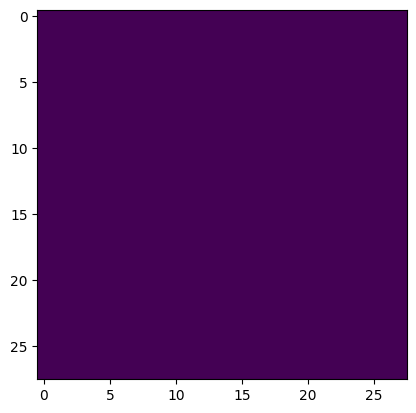

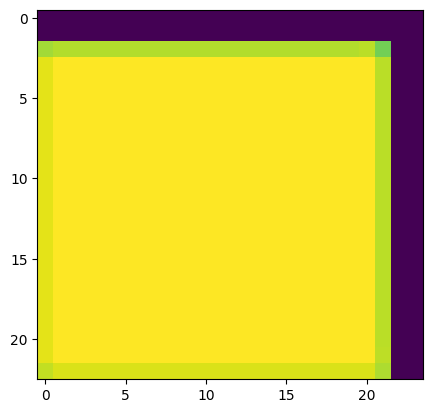

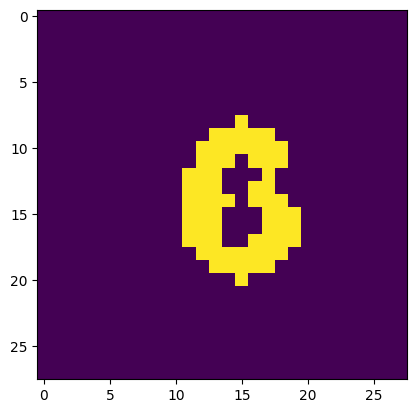

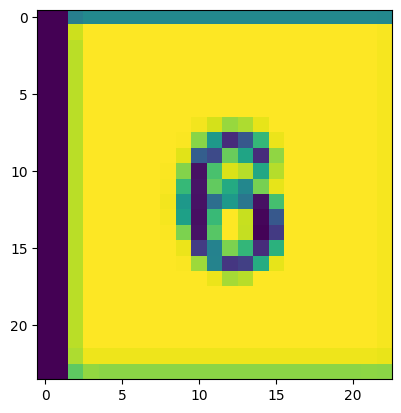

6.0


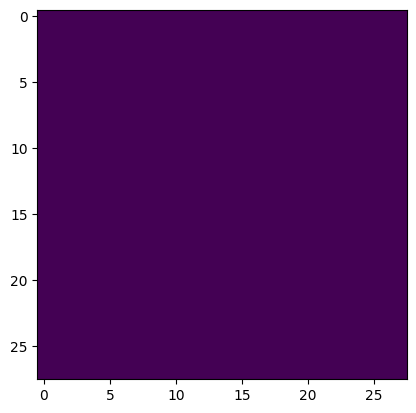

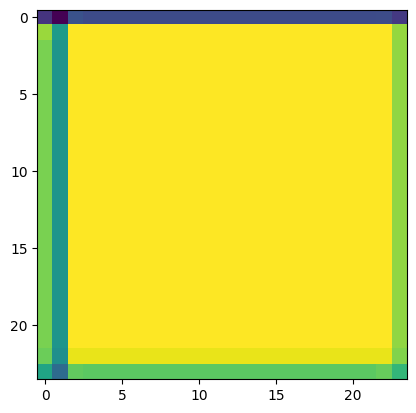

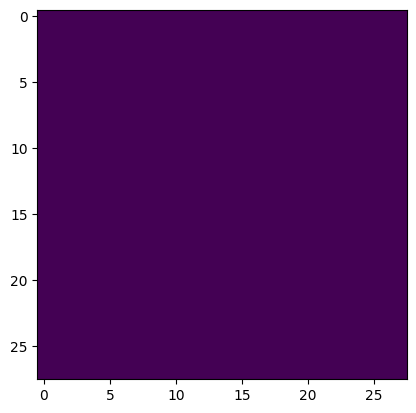

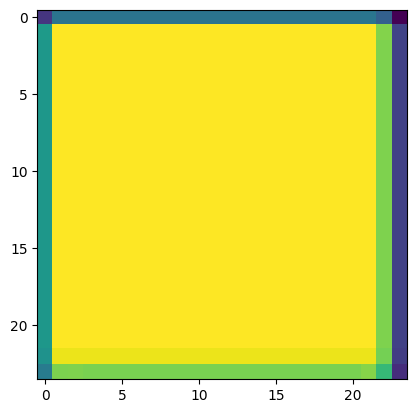

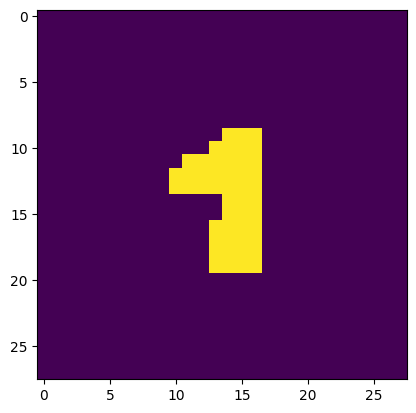

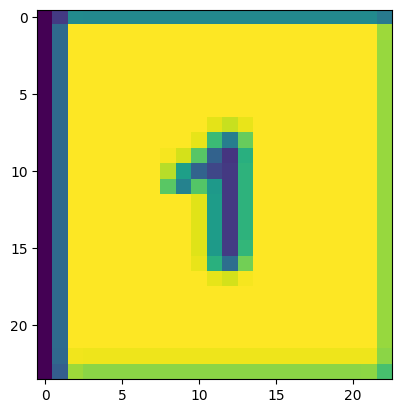

1.0


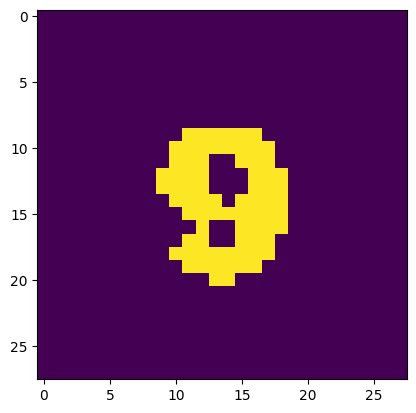

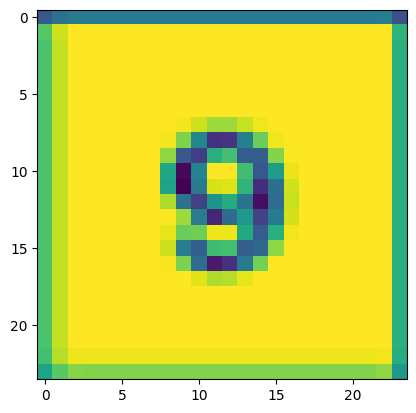

9.0


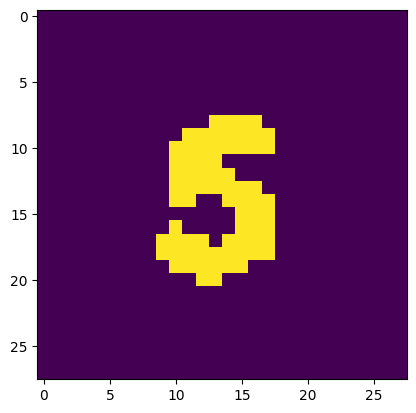

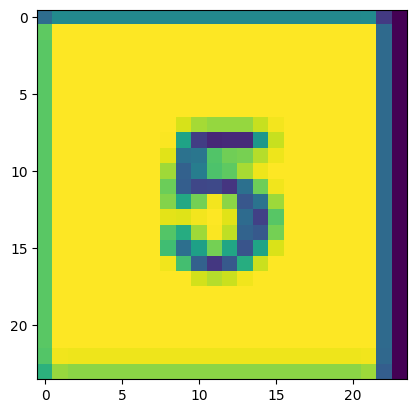

5.0


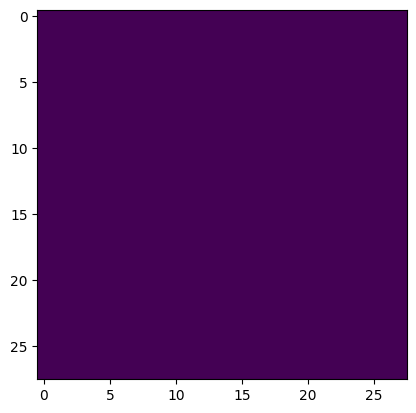

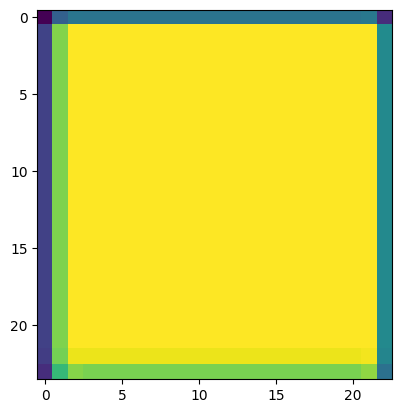

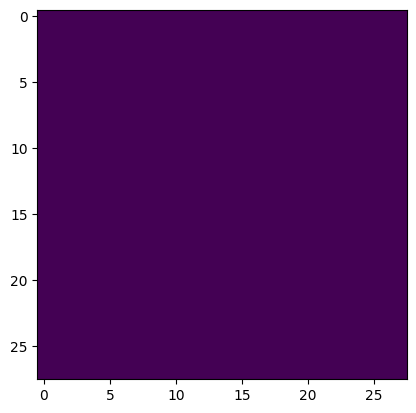

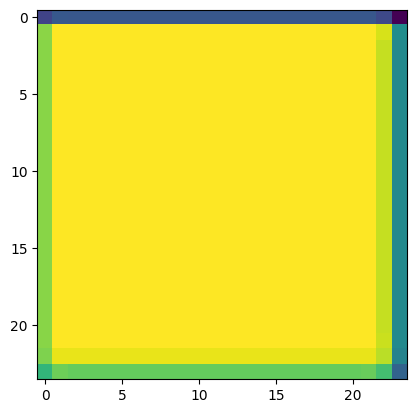

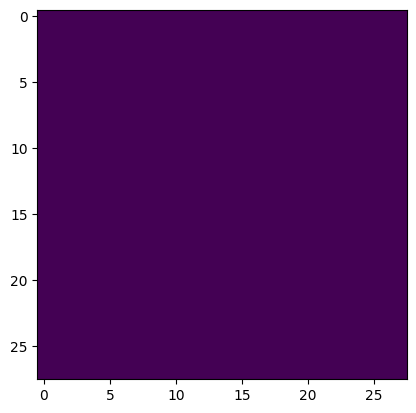

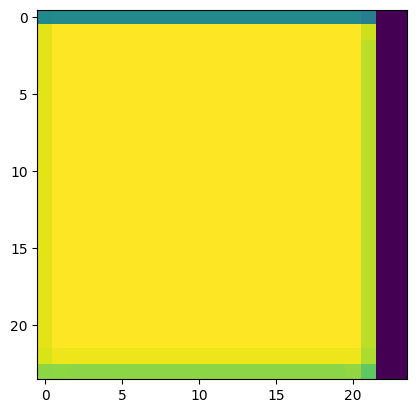

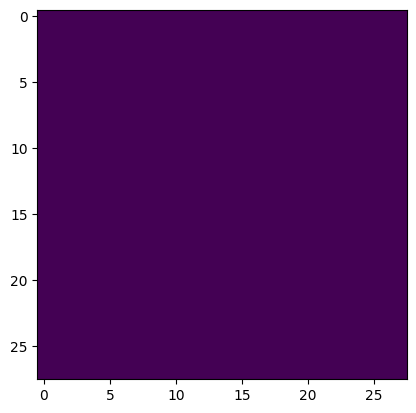

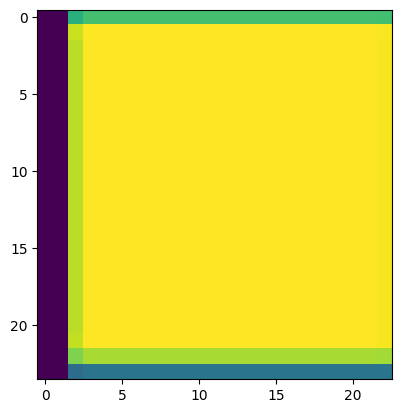

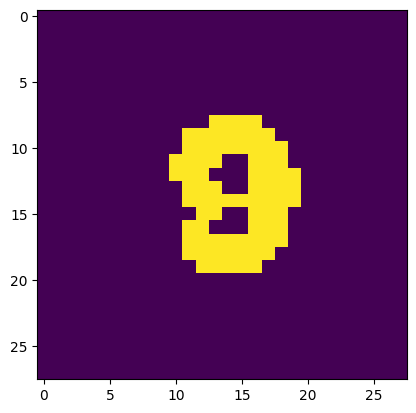

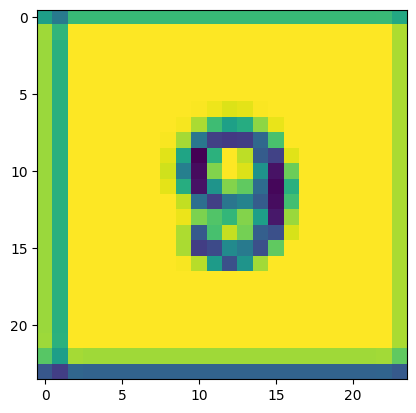

9.0


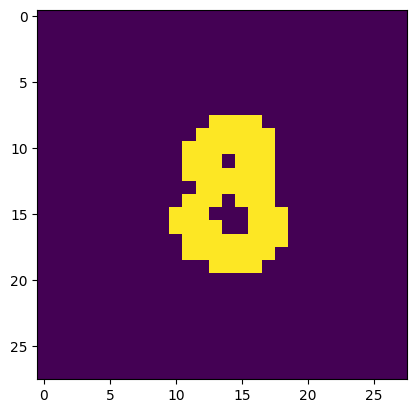

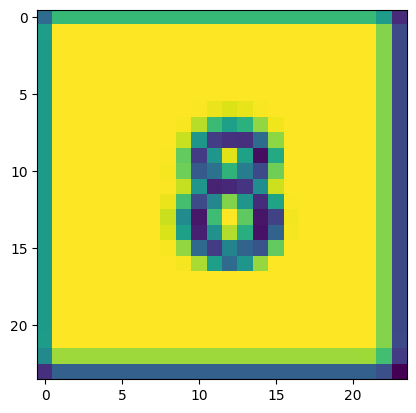

3.0


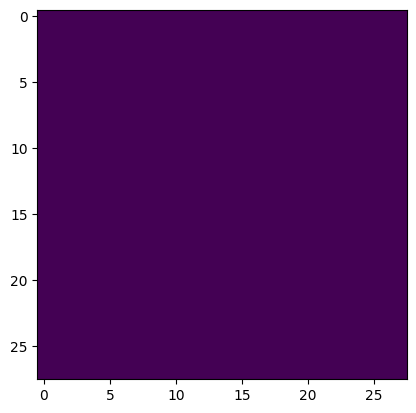

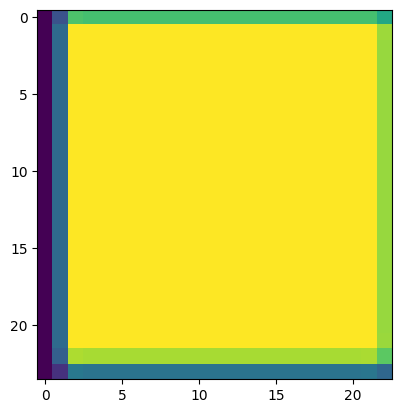

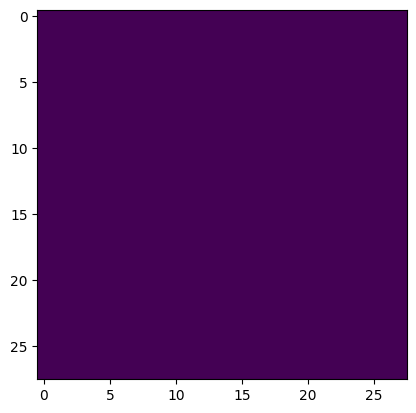

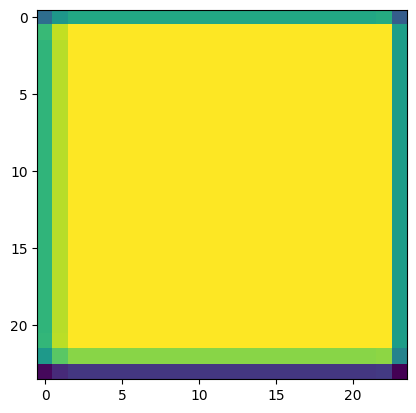

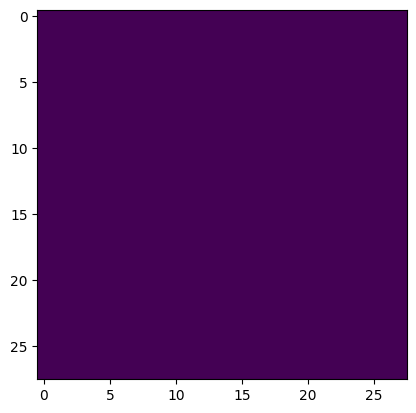

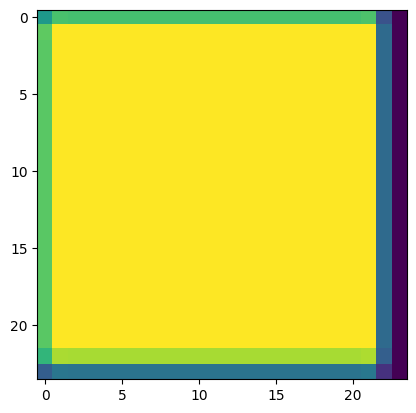

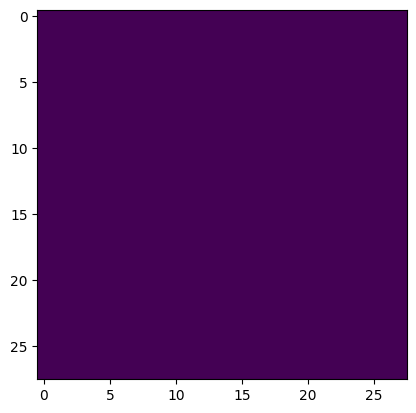

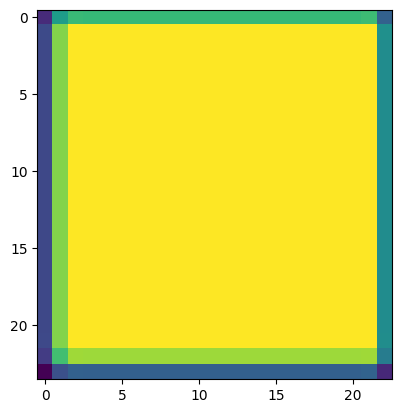

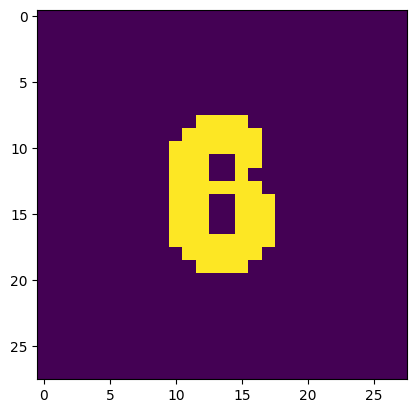

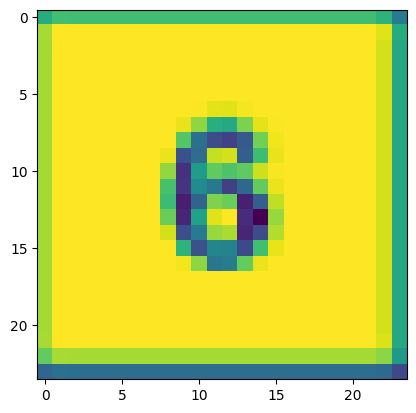

6.0


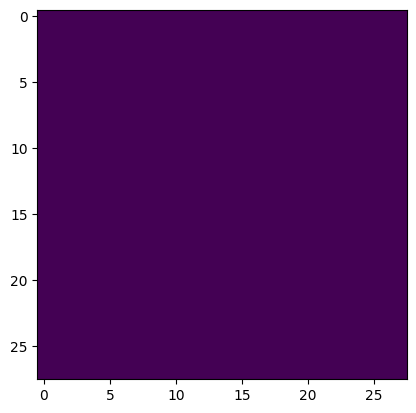

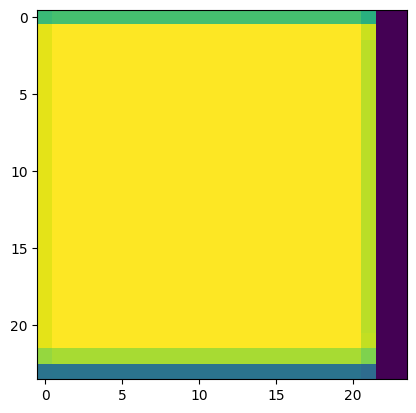

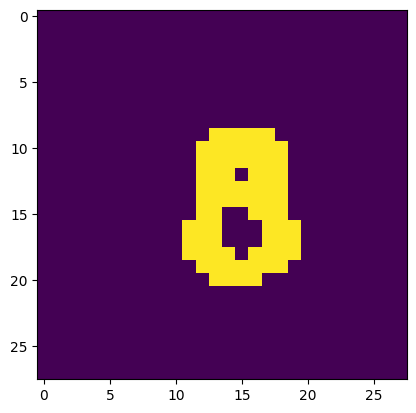

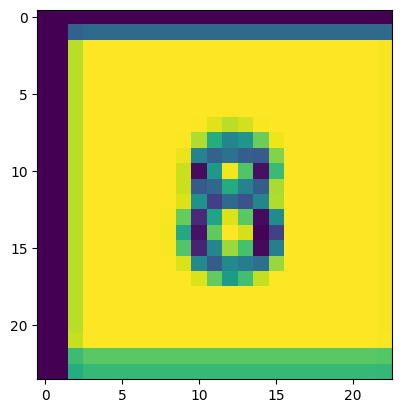

8.0


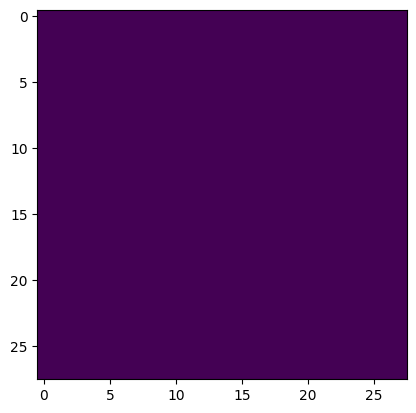

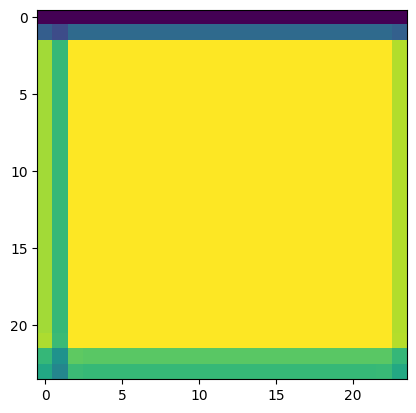

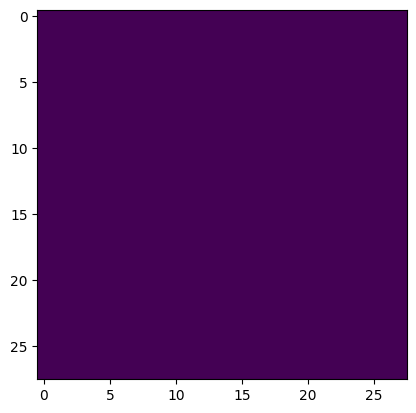

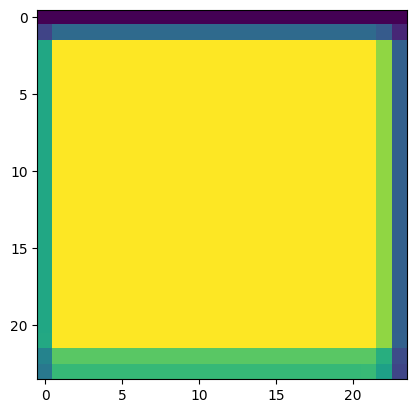

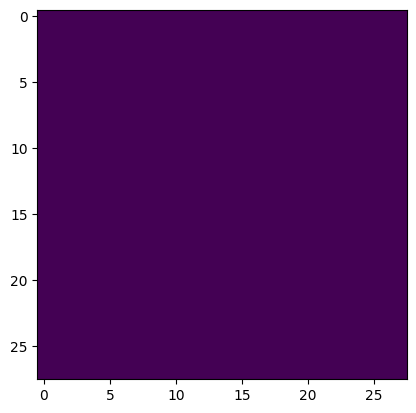

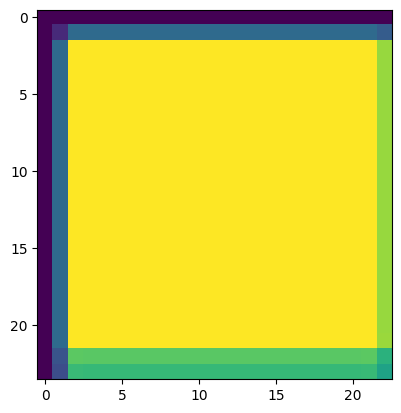

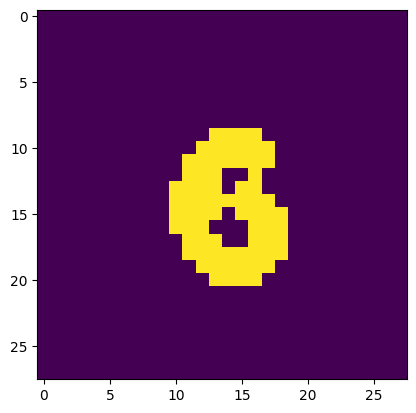

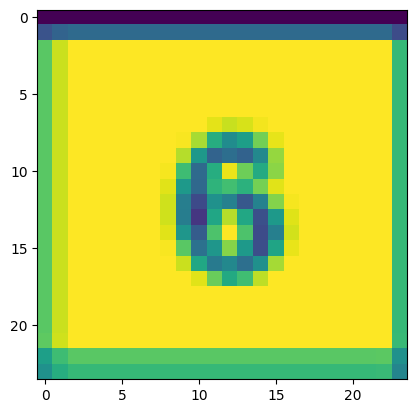

6.0


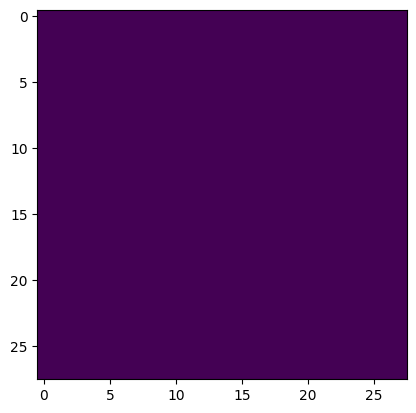

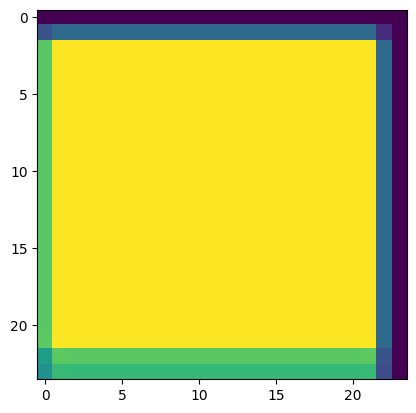

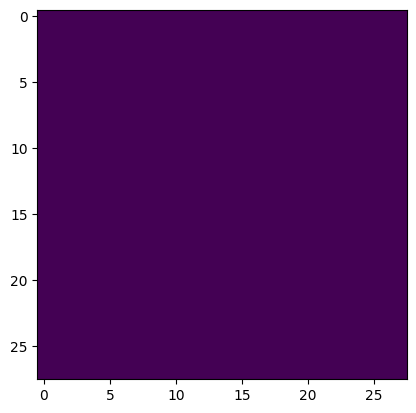

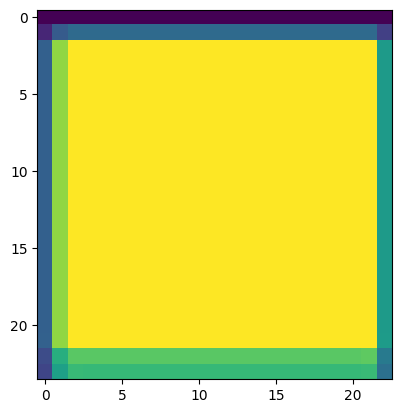

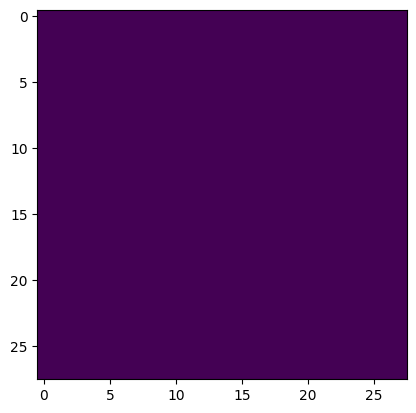

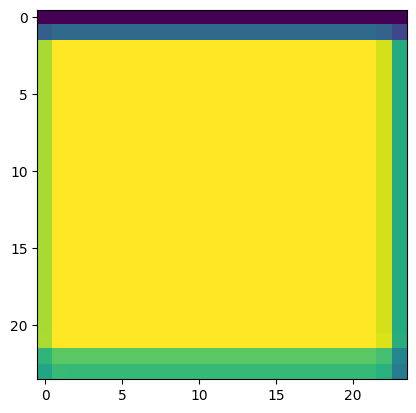

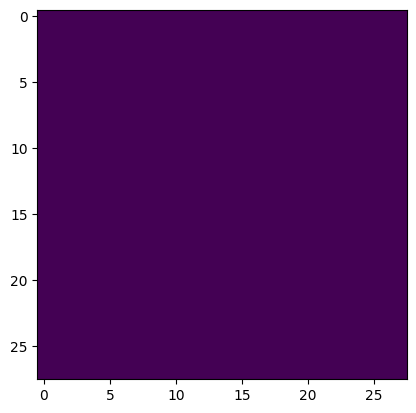

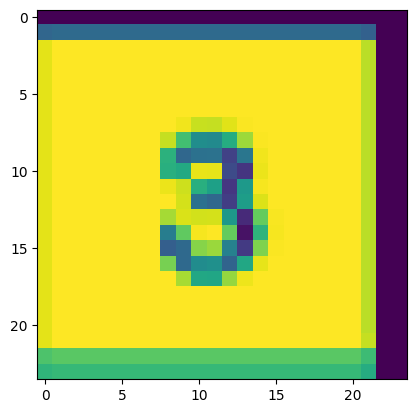

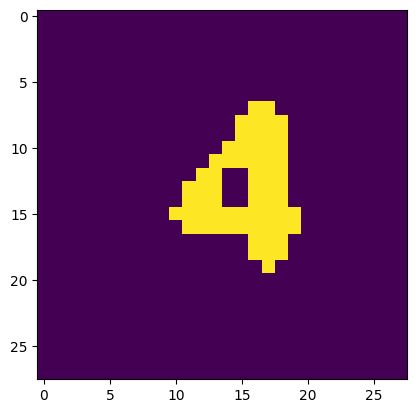

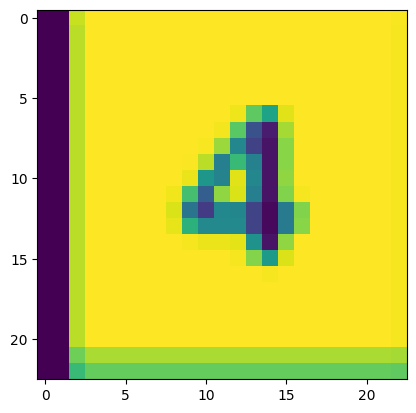

4.0


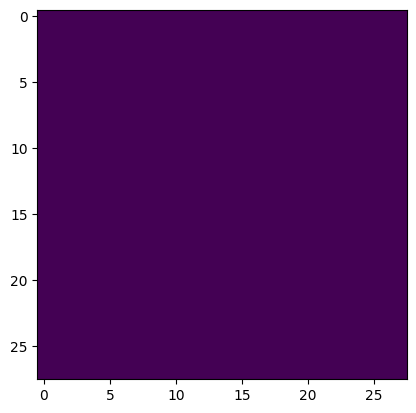

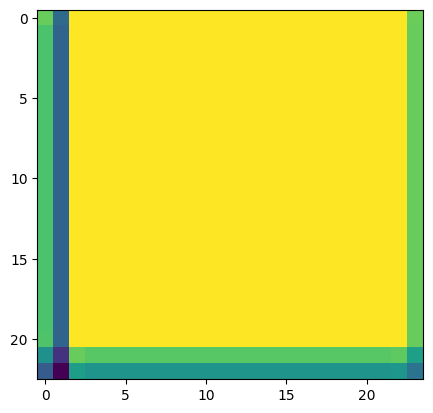

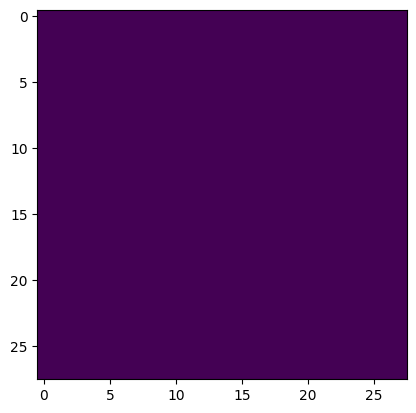

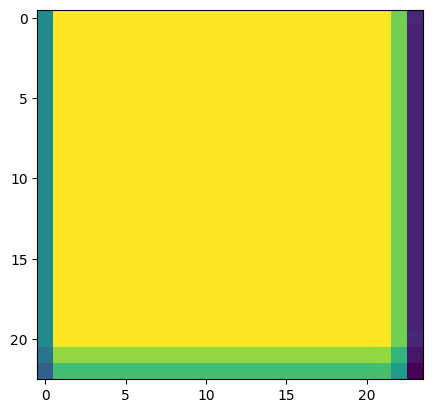

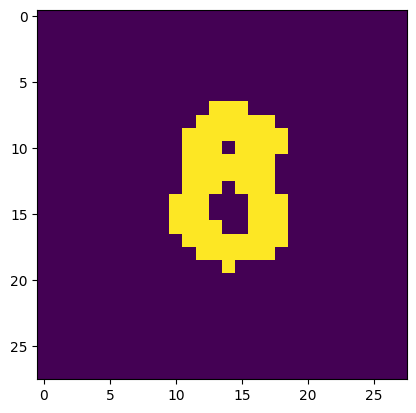

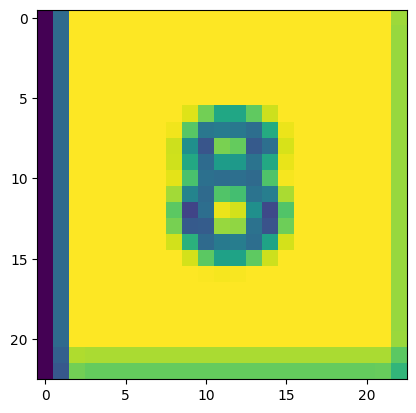

6.0


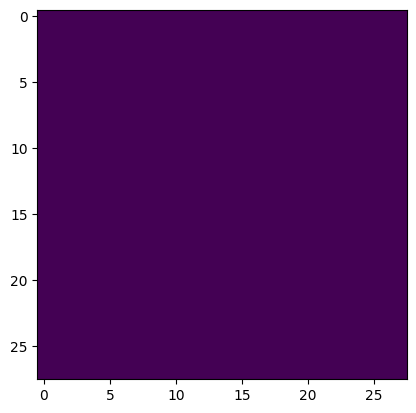

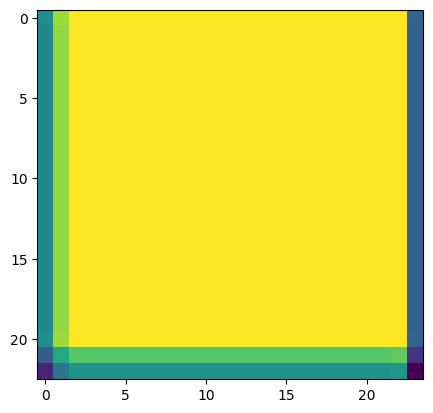

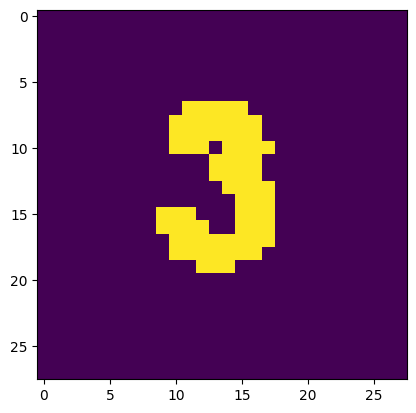

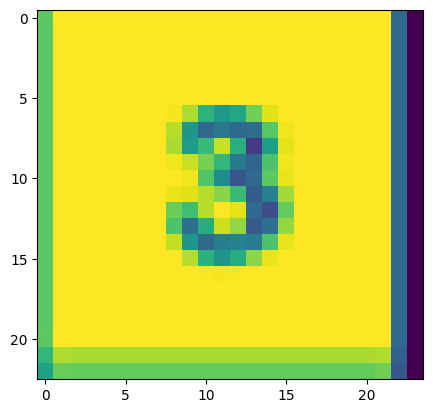

3.0


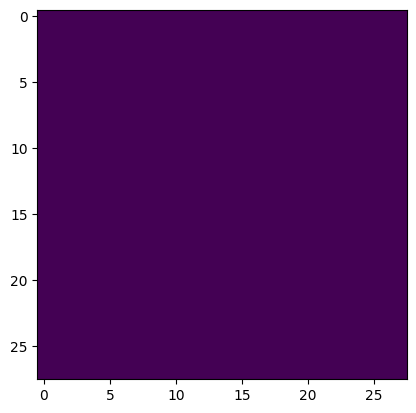

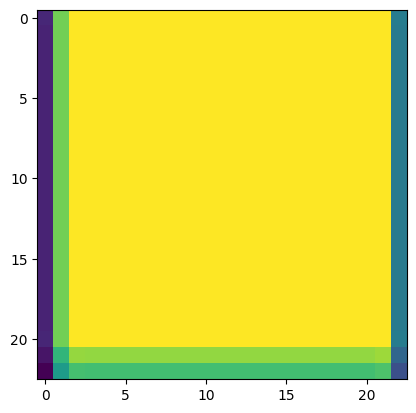

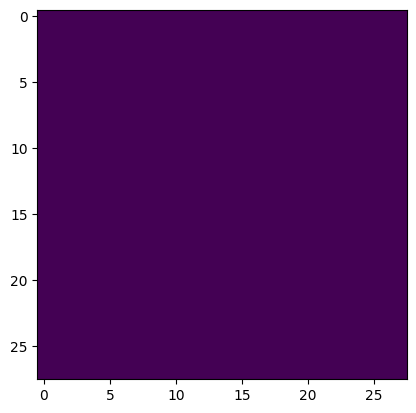

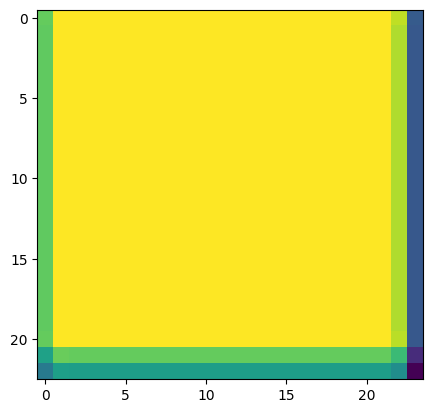

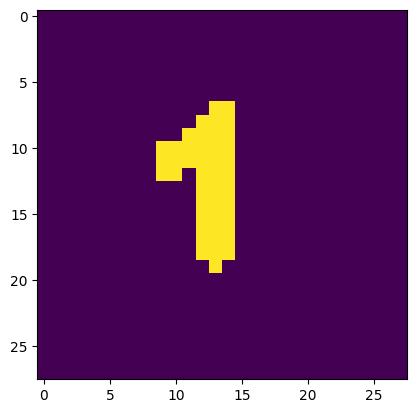

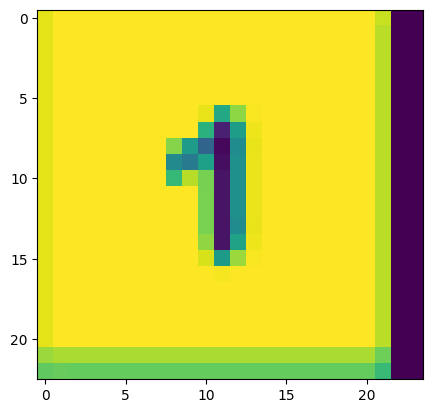

1.0


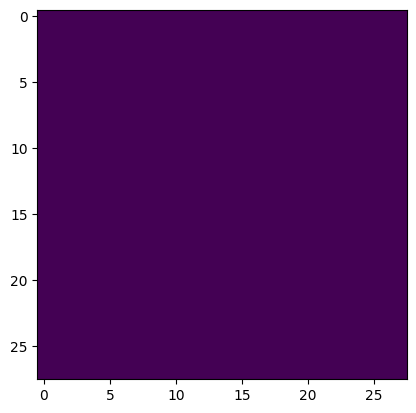

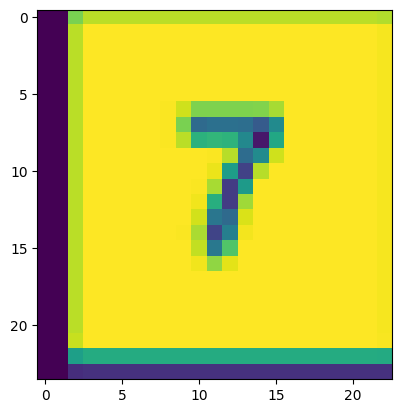

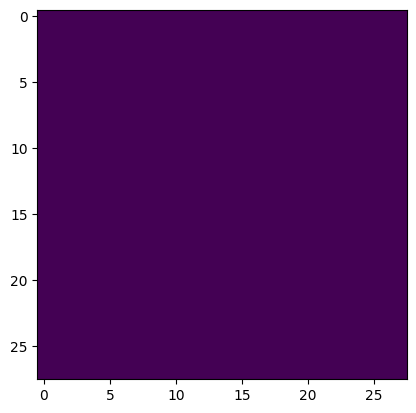

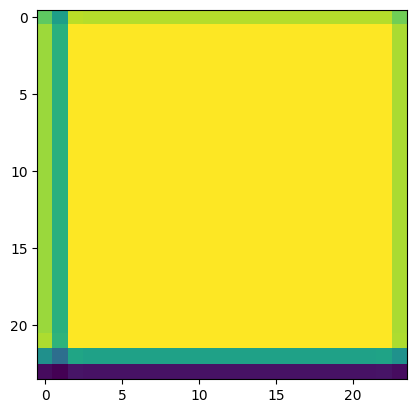

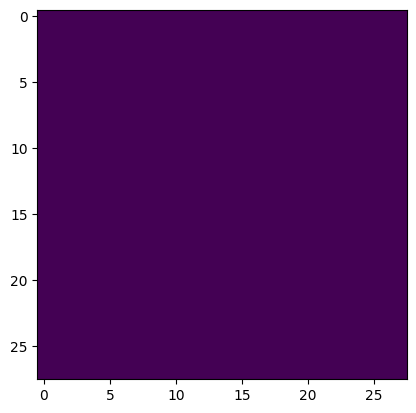

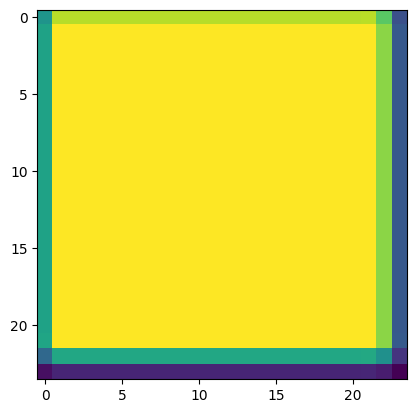

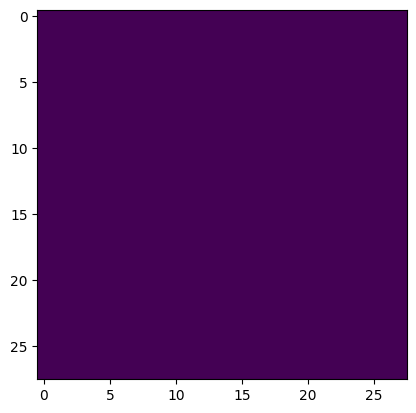

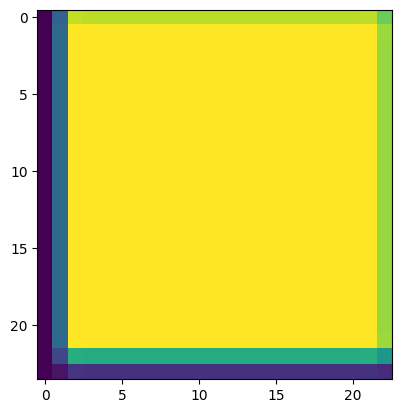

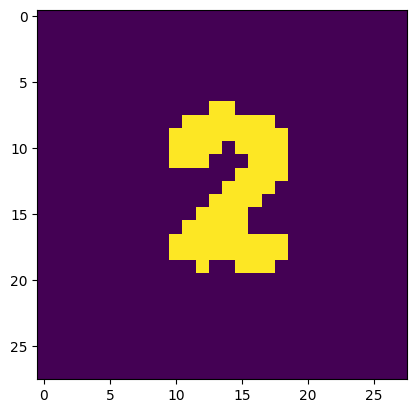

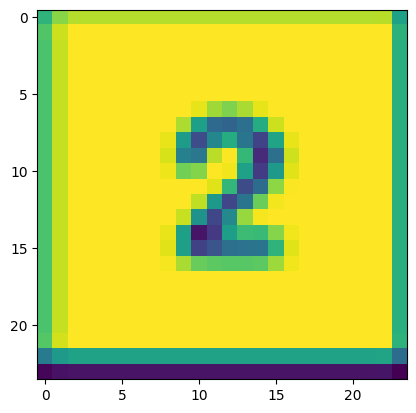

2.0


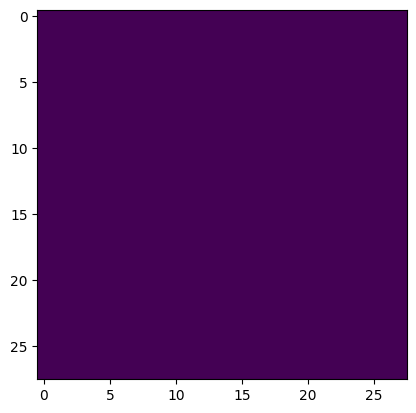

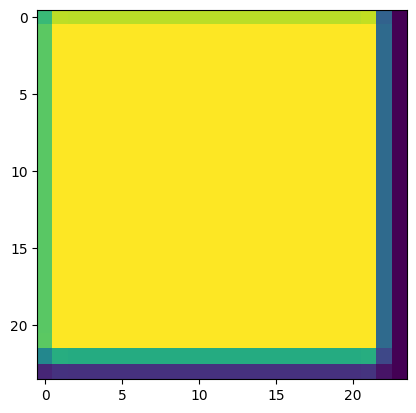

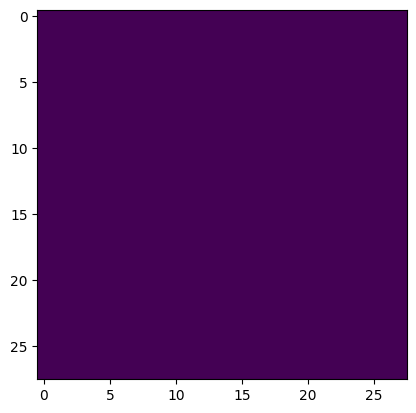

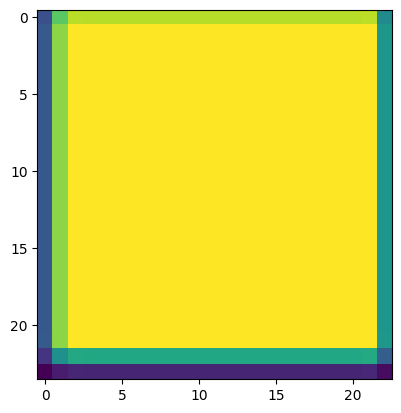

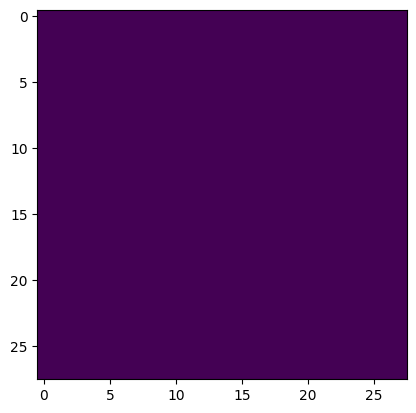

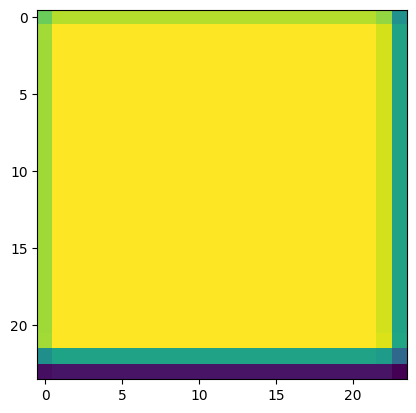

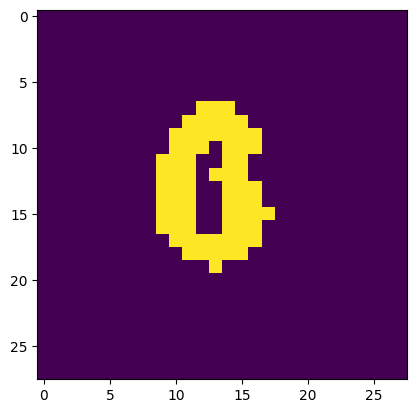

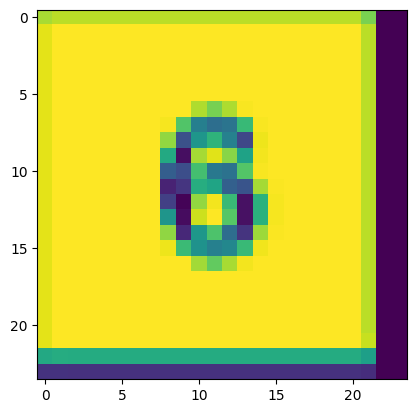

6.0


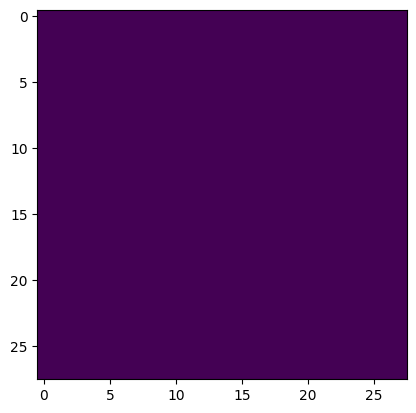

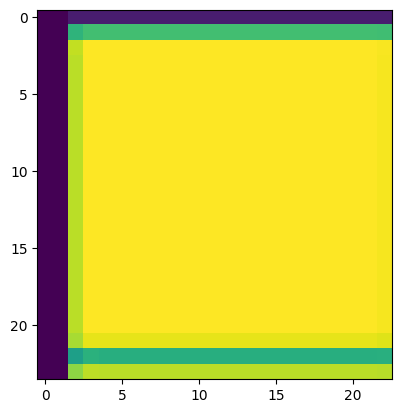

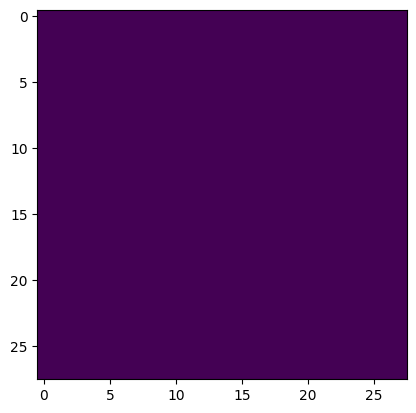

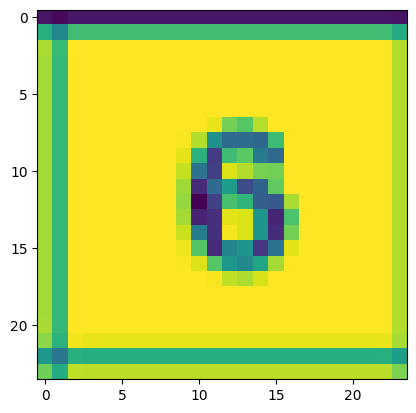

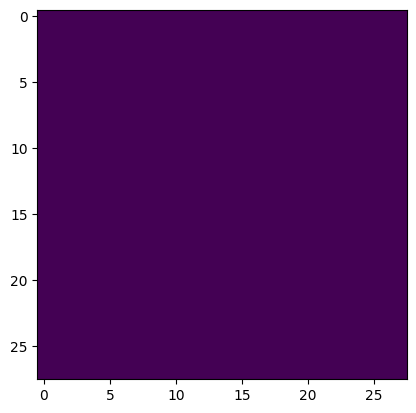

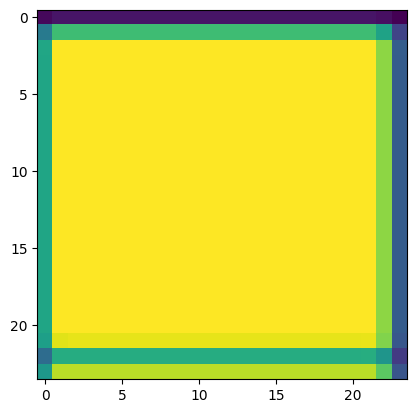

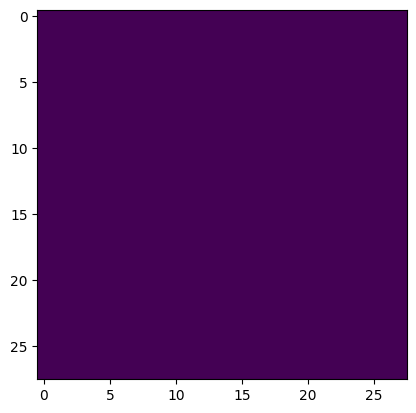

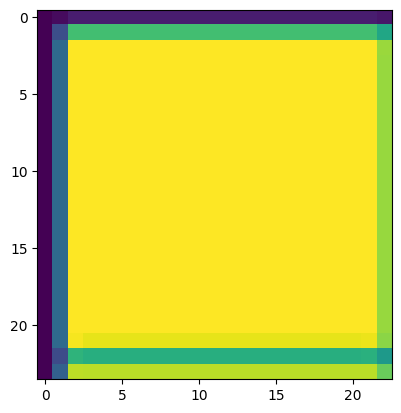

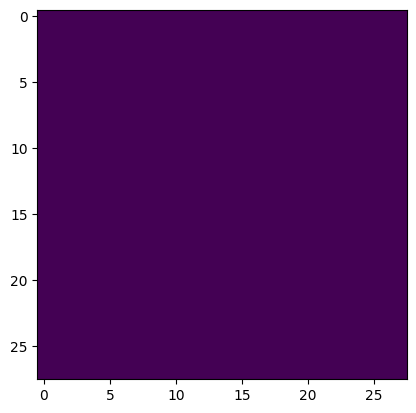

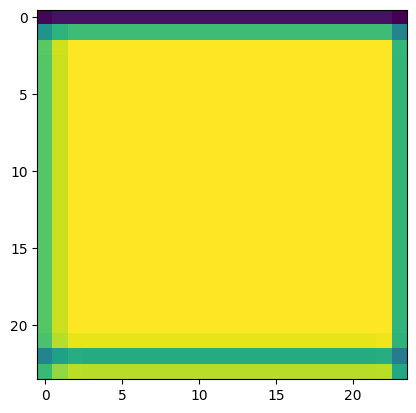

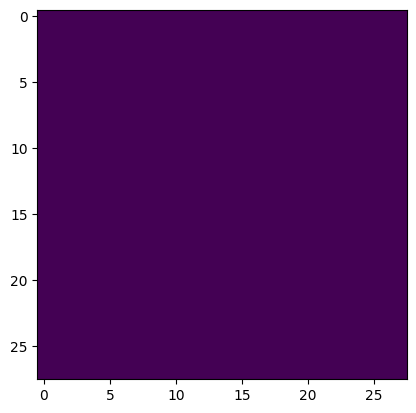

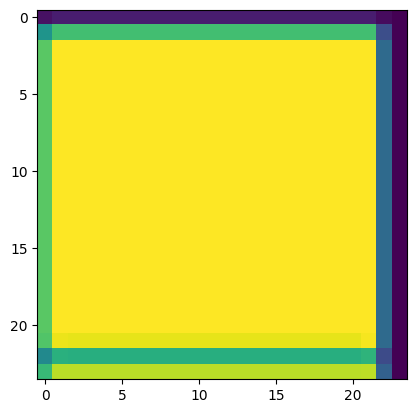

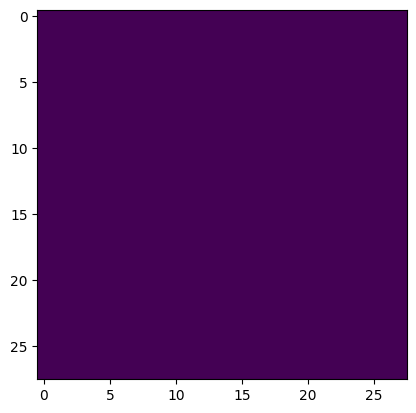

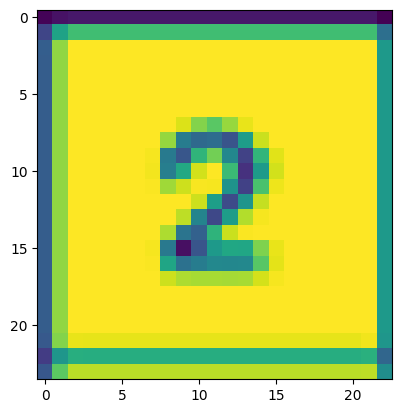

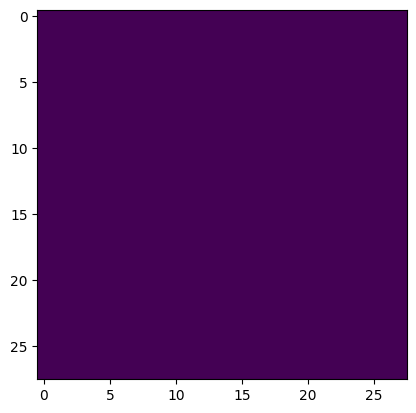

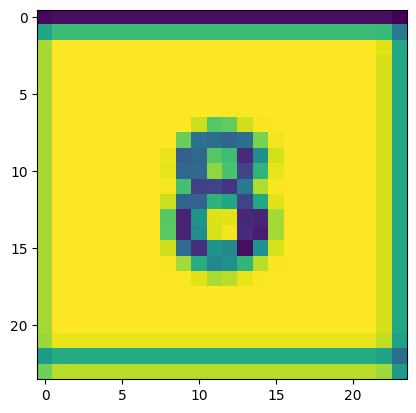

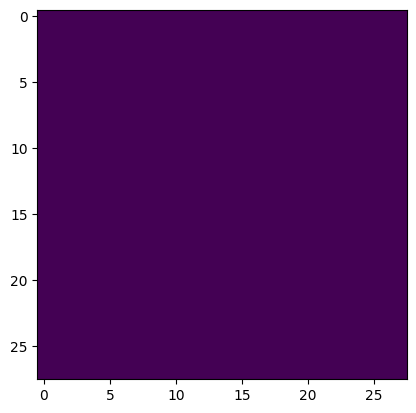

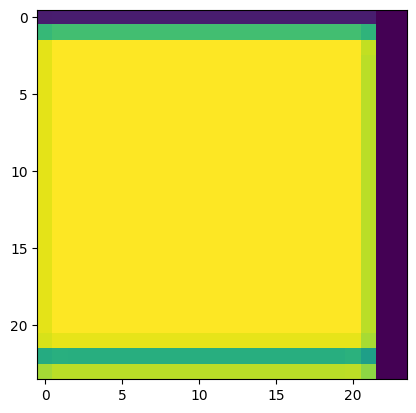

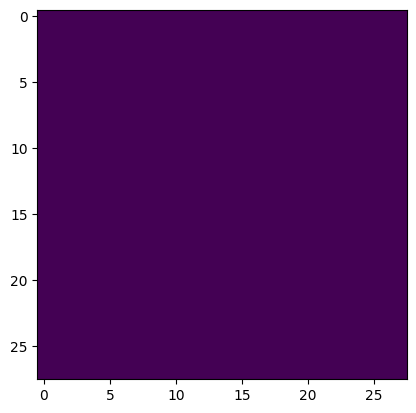

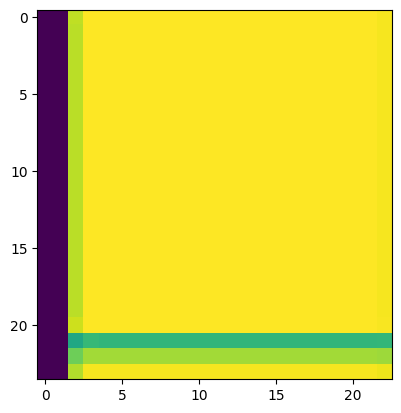

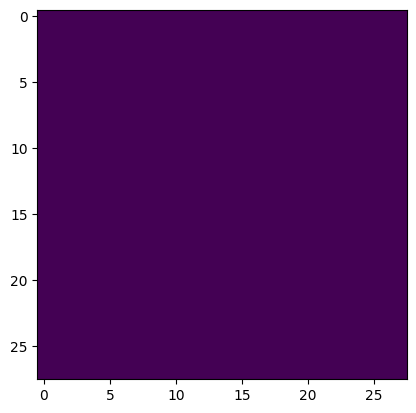

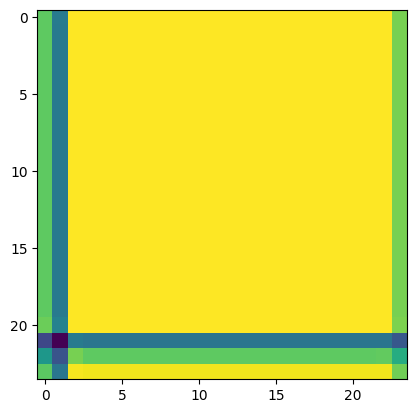

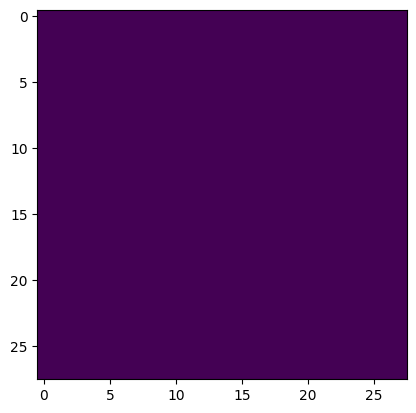

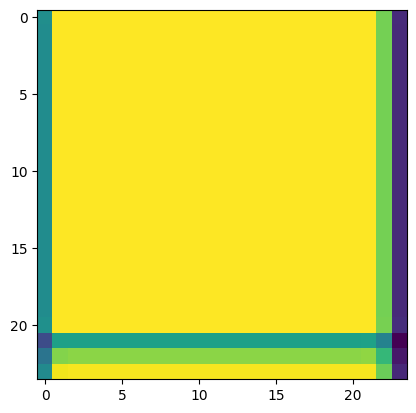

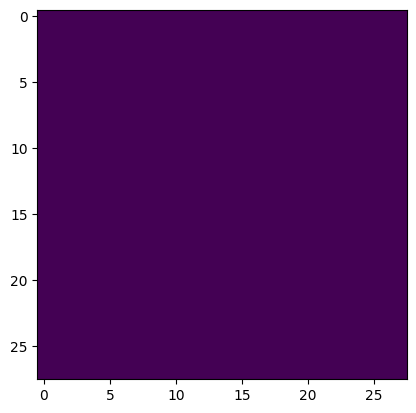

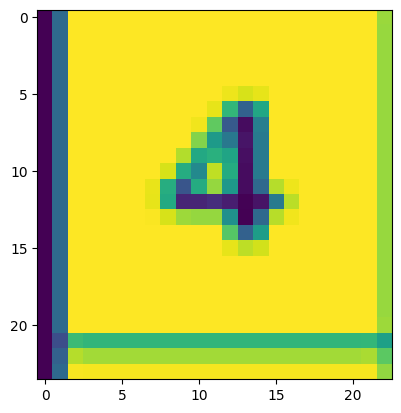

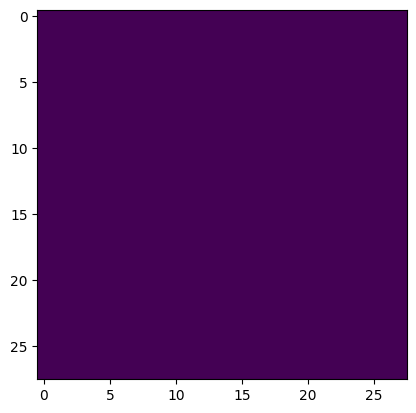

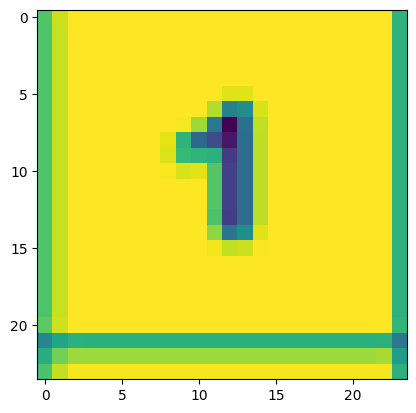

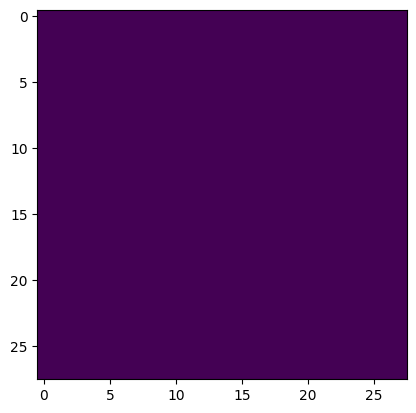

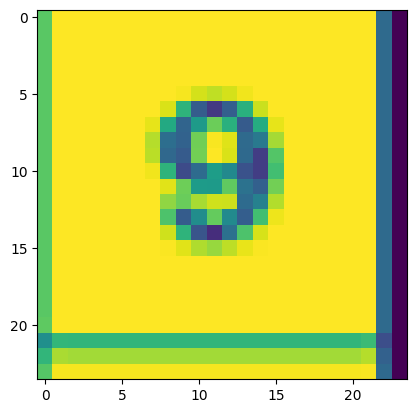

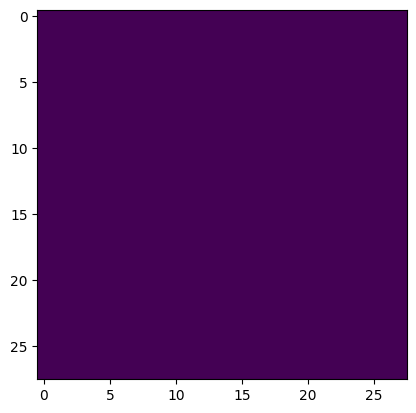

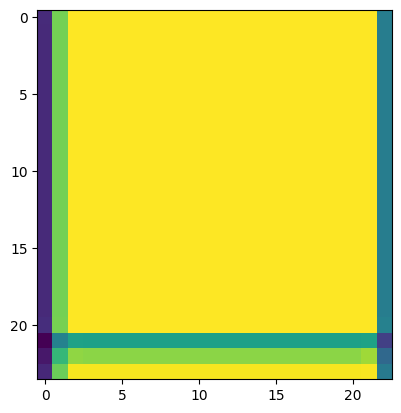

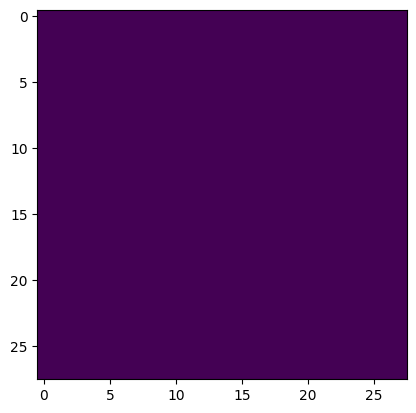

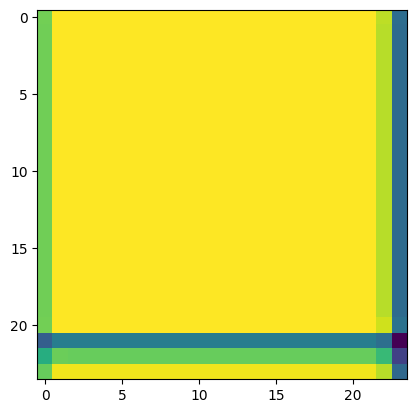

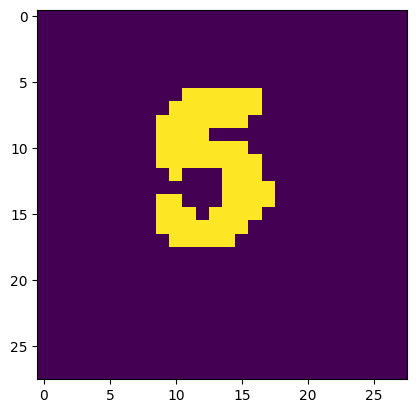

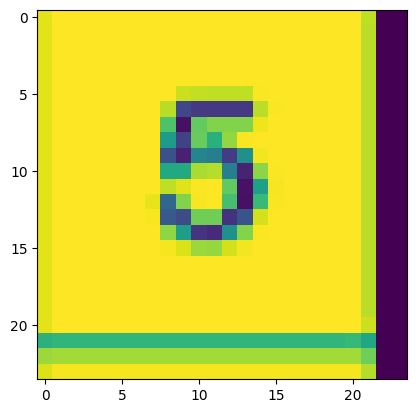

5.0


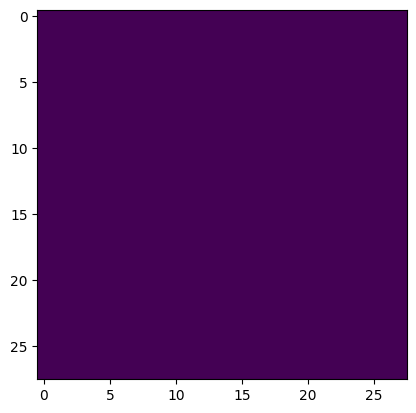

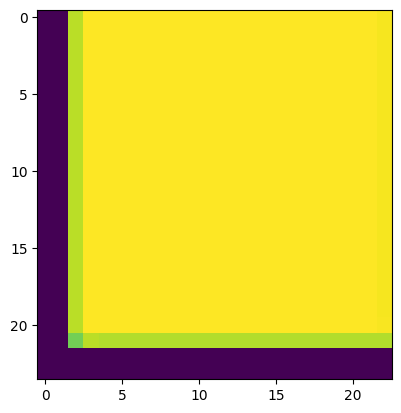

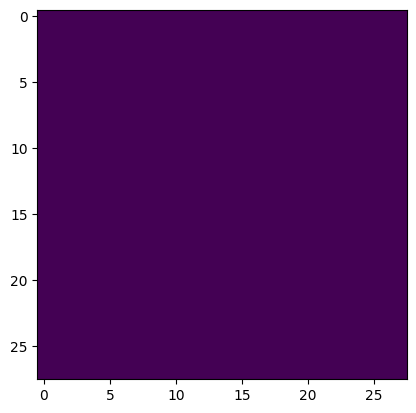

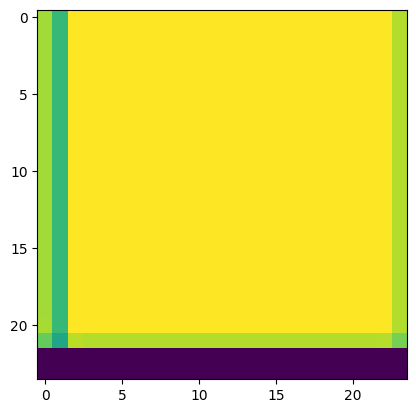

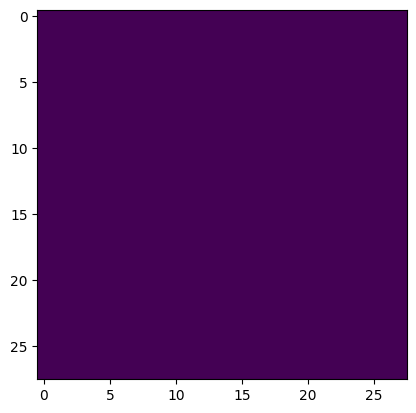

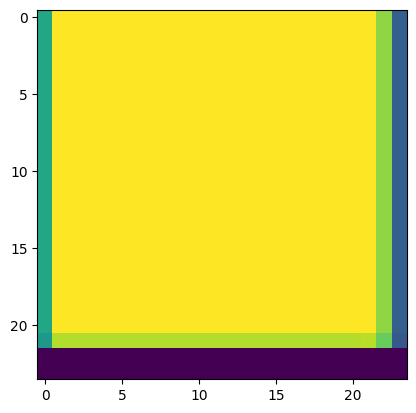

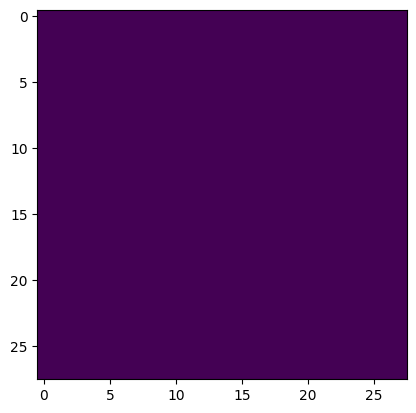

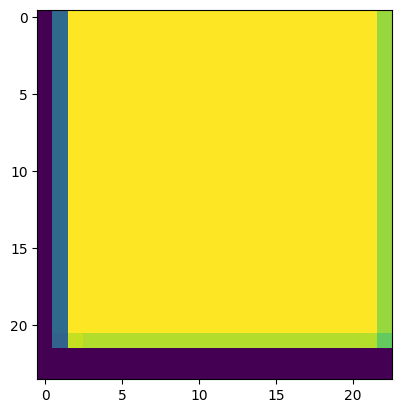

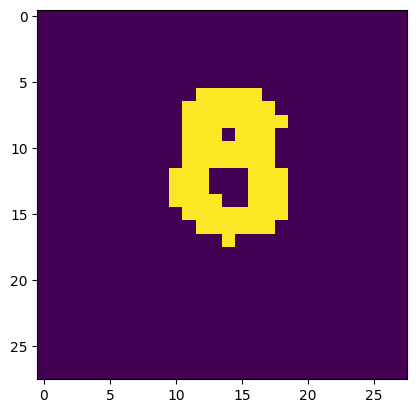

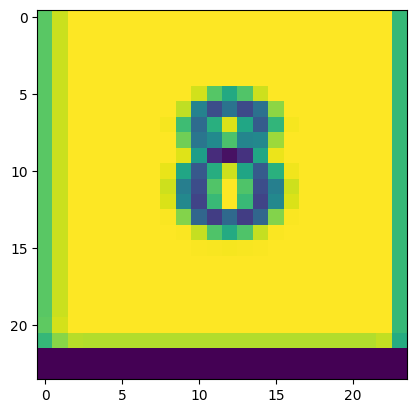

6.0


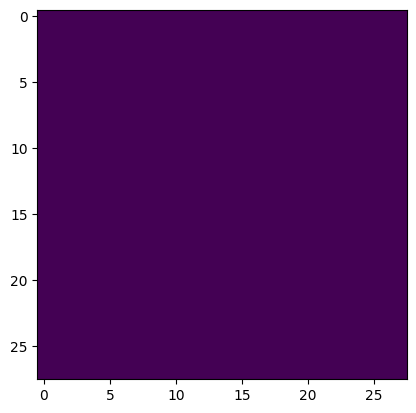

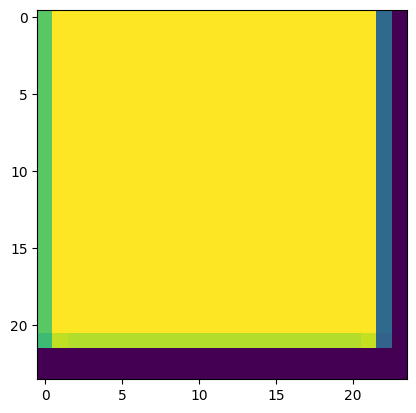

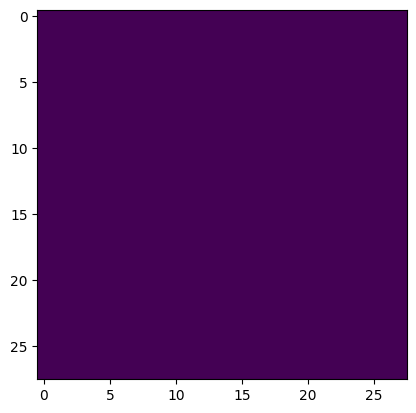

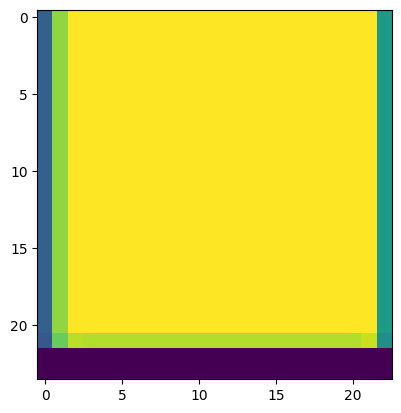

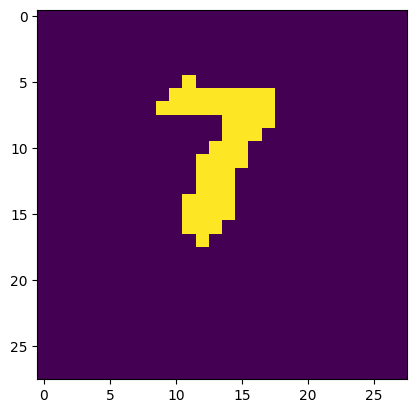

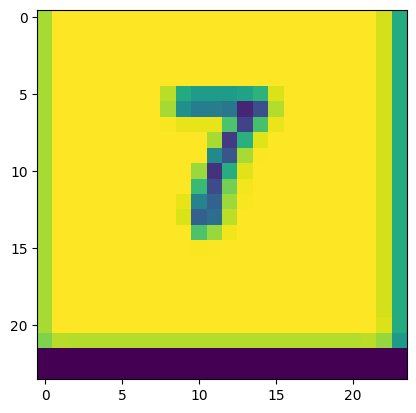

7.0


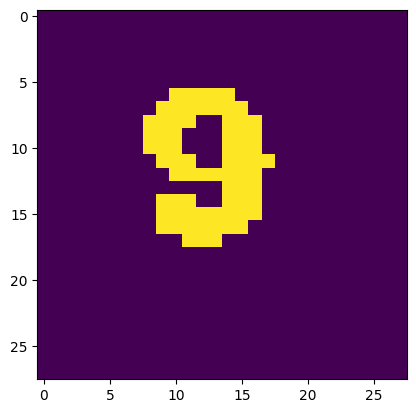

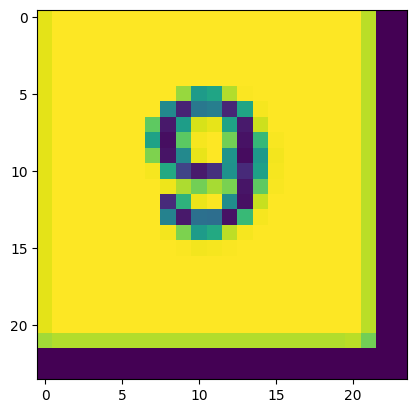

9.0
[[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [6. 0. 0. 1. 9. 5. 0. 0. 0.]
 [0. 9. 3. 0. 0. 0. 0. 6. 0.]
 [8. 0. 0. 0. 6. 0. 0. 0. 0.]
 [4. 0. 0. 6. 0. 3. 0. 0. 1.]
 [0. 0. 0. 0. 2. 0. 0. 0. 6.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 5.]
 [0. 0. 0. 0. 6. 0. 0. 7. 9.]]


In [53]:
A = recognize_sudoku(image)
print(A)